Tham khảo:

 [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/multi-armed-bandit-problem-in-reinforcement-learning/)

[github](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html)

**Bài toán**: 
- Có $N$ máy đánh bạc một tay (loại máy có "cánh tay" bên cạnh để người chơi kéo để máy chạy lại)
- Sau mỗi lần kéo máy sẽ trả lại một phần thưởng từ một phân phối xác suất chưa xác định 
- Một số máy có phần thưởng cao hơn các máy khác (nhưng ta không biết)
- Số lần kéo thường là hữu hạn

**Mục tiêu**: Tối đa hóa phần thưởng nhận được 

### Epsilon-Greedy: 
- Mô phỏng bài toán Multi-Armed Bandit 
- Triển khai thuật toán Epsilon-Greedy: 
<br> Với xác suất $\epsilon$ ($\epsilon$ nhỏ), chọn một cánh tay ngẫu nhiên 
<br> Ngược lại, chọn hành động tham lam 



In [90]:
import numpy as np
import matplotlib.pyplot as plt 

In [91]:
class EpsilonGreedy:
    ''' 
    Đại diện cho một policy: Chọn một hành động khám phá với xác suất nhỏ, 
    còn lại là tham lam 
    '''
    def __init__(self, n_arms, epsilon):
        ''' 
        Hàm dựng: 
        - n_arms: số cánh tay có thể chọn
        - epsilon: xác suất chọn hành động khám phá
        - counts([]): mảng đếm, để tính values 
        - values([])
        '''
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
    
    def select_arm(self):
        '''
        Xác suất explore: epsion, nên xs chọn một hành động trong TH này là epsilon/n => lấy pp đều 
        Còn lại: chọn hành động tham lam 
        '''
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)
    
    def update(self, chosen_arm, reward):
        ''' 
        Với arm được chọn: V[t] = (n-1)/n * V[t-1] + 1/n * R
        Các arm khác không thay đổi 
        '''
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value_past = self.values[chosen_arm]
        self.values[chosen_arm] = (n-1) / n * value_past + 1/n * reward

In [92]:
''' 
Thiết lập trạng thái ban đầu 
true_means : kỳ vọng reward của một máy 
''' 
np.random.seed(6)
true_means = np.random.randn(10)
print(f"Sum of mean is: {sum(true_means)}")
print(f"Actual mean rewards for each arm: \n {np.round(true_means, 2)}")
print(f"The best arm is #{np.argmax(true_means)} with a mean of {np.max(true_means):.2f} \n")

Sum of mean is: -1.015211911465167
Actual mean rewards for each arm: 
 [-0.31  0.73  0.22 -0.9  -2.49  0.91  1.13 -1.51  1.64 -0.43]
The best arm is #8 with a mean of 1.64 



Tuy được sinh ra ngẫu nhiên từ phân phối chuẩn, nhưng `true_means` đảm bảo tổng kỳ vọng của tất cả các máy nhỏ hơn 0. 

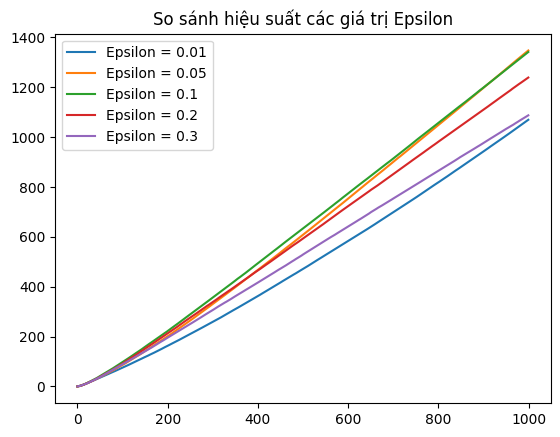

In [93]:
''' Mẫu chạy thử '''
n_arms = 10
epsilon = [0.01, 0.05, 0.1, 0.2, 0.3]
T = 1000
n_runs = 200 # Chạy nhiều lần để lấy trung bình 

''' Lưu kết quả '''
results = {}

for eps in epsilon:
    all_runs_reward = [] #chạy 200 lần và lấy trung bình 

    for run in range(n_runs):
        agent = EpsilonGreedy(n_arms, eps)
        
        rewards = []
        for t in range(T):
            arm_to_pull = agent.select_arm()
            reward = np.random.randn() + true_means[arm_to_pull]
            agent.update(arm_to_pull, reward)
            rewards.append(reward)

        all_runs_reward.append(rewards)

    results[eps] = np.mean(all_runs_reward, axis = 0)

for eps, avg_reward in results.items():
    plt.plot(np.cumsum(avg_reward), label=f'Epsilon = {eps}')

plt.legend()
plt.title("So sánh hiệu suất các giá trị Epsilon")
plt.show()

Từ biểu đồ ta thấy, khi $\epsilon = 0.05$ hoặc $\epsilon = 0.1$ là cho kết quả tốt nhất với test `n_arms = 10` và `T = 1000`

### So sánh với UCB 

In [94]:
class UCB:
    def __init__(self, n_arms, c):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_counts = 0
        self.c = c
    
    def select_arm(self):
        ucb_values = self.values + self.c * np.sqrt( np.log(self.total_counts+1) / (self.counts + 1e-5))
        return np.argmax(ucb_values)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value_past = self.values[chosen_arm]
        self.values[chosen_arm] = (n-1) / n * value_past + 1/n * reward

In [95]:
n_arms = 10
T = 1000
n_runs = 200

eps = 0.1
c = 1 

In [100]:

all_runs_reward = [] 

for run in range(n_runs):
    agent = EpsilonGreedy(n_arms, epsilon=eps)
    
    rewards = []
    for t in range(T):
        arm_to_pull = agent.select_arm()
        reward = np.random.randn() + true_means[arm_to_pull]
        agent.update(arm_to_pull, reward)
        rewards.append(reward)

    all_runs_reward.append(rewards)

results = np.mean(all_runs_reward, axis = 0)

''' Với UCB '''

all_runs_reward_c = [] #chạy 200 lần và lấy trung bình 

for run in range(n_runs):
    agent = UCB(n_arms, c)
    
    rewards = []
    for t in range(T):
        arm_to_pull = agent.select_arm()
        reward = np.random.randn() + true_means[arm_to_pull]
        agent.update(arm_to_pull, reward)
        rewards.append(reward)

    all_runs_reward_c.append(rewards)

results_c = np.mean(all_runs_reward_c, axis = 0)

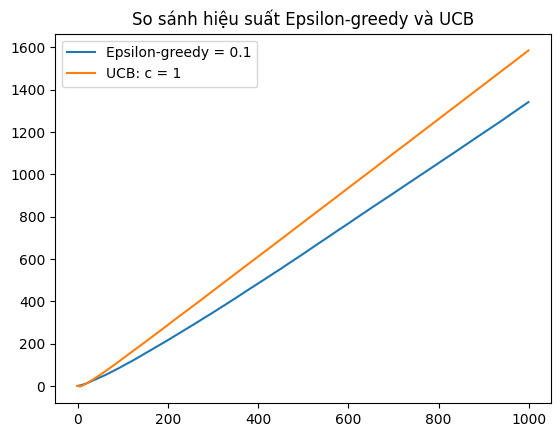

In [102]:
''' Vẽ biểu đồ '''

plt.plot(np.cumsum(results), label=f'Epsilon-greedy = {eps}')
plt.plot(np.cumsum(results_c), label=f'UCB: c = {c}')

plt.legend()
plt.title("So sánh hiệu suất Epsilon-greedy và UCB")
plt.show()